In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from scipy import stats as st
import scipy.stats as stats
import math as mth

# Сборный проект 2. Анализ  воронки событий мобильного приложения и исследование результатов A/A/B-эксперимента

**Описание:**

Cтартап, который продаёт продукты питания, планирует разобраться, как ведут себя пользователи мобильного приложения и внести изменения в интерфейс (поменять шрифт). Для этого нужно проанализировать воронку событий и исследовать результаты A/A/B-эксперимента.

**Цель:**

- Проанализироовать воронку событий;
- исследовать результаты A/A/B-эксперимента;
- принять решение о смене шрифта по результатам A/A/B-теста. 

**Описание данных:**

Каждая запись в логе — это действие пользователя, или событие.
EventName — название события;
DeviceIDHash — уникальный идентификатор пользователя;
EventTimestamp — время события;
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


**Этапы работы:**

**Часть 1. Изучение и подготовка данных**

1) Изучить данные;
2) заменить названия столбцов на удобные;
3) проверить пропуски и типы данных;
4) добавить столбец даты и времени, а также отдельный столбец дат;
5) посчитать, сколько всего событий в логе;
6) посчитать, сколько всего пользователей в логе;
7) посчитать, сколько в среднем событий приходится на пользователя;
8) определить период данных,найти максимальную и минимальную дату;
9) изучить, как меняется количество данных: построить столбчатую диаграмму;
10) проверить, что есть пользователи из всех трёх экспериментальных групп.

**Часть 3. Изучение воронки событий**

1) Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте;
2) посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей;
3) посчитать долю пользователей, которые хоть раз совершали событие;
4) проанализировать, в каком порядке происходят события;
5) по воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем);
6) определить, на каком шаге теряется больше всего пользователей;
7) определить, какая доля пользователей доходит от первого события до оплаты.

**Часть 4. Изучение результатов эксперимента**

1) Посчитать, сколько пользователей в каждой экспериментальной группе;
2) проверить, находят ли статистические критерии разницу между контрольными группами 246 и 247;
3) выбрать самое популярное событие и посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. С помощью функции сделать то же самое для всех других событий;
4) сравнить результаты экспериментальной группы 248 с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Сделать выводы из эксперимента;
5) описать, какой уровень значимости был выбран при проверке статистических гипотез и посчитать, сколько проверок гипотез было сделано.

### Общая информация

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


В датафрейме нет пропущенных значений. Для удобства работы необходимо переименовать столбцы и добавить столбцы с датой в формате даты.

### Подготовка данных

#### Названия столбцов

In [5]:
data = data.rename(
    columns = {
        'EventName': 'event_name', 
        'DeviceIDHash': 'device_id_hash',
        'EventTimestamp': 'event_timestamp',
        'ExpId': 'exp_id'
    }
)

In [6]:
data

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Названия столбцов теперь указаны в змеином регистре, который удобнее использовать для работы и чтения.

#### Проверка пропусков и типов данных

Проверим тип данных:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
data.duplicated().sum()

413

В данных имеется 413 полных дубликатов. Из 244126 строк это очень малая часть, поэтому мы просто их удалим.

In [9]:
data = data.drop_duplicates(keep='first')

In [10]:
data.duplicated().sum()

0

In [11]:
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

#### Добавление столбца даты и времени, а также столбца дат

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


Для удобства анализа данных с учетом времени добавим столбец с датой, а также столбец с датой временем:

In [13]:
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')

In [14]:
data['event_date'] = pd.to_datetime(data['event_datetime']).dt.date

In [15]:
data

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


**Результаты подготовки данных о логах:**

- установлено, что в датафрейме нет пропусков;
- выявлены и удалены полные дубликаты - 413 строчек;
- добавлены столбцы с датой и датой и временем в формате datetime64;
- названия столбцов приведены к змеиному регистру.

### Изучение и проверка данных

#### Количество событий в логе

In [16]:
data['event_name'].count()

243713

In [17]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Данные содержат 243713 событий и 5 видов событий:

- MainScreenAppear
- PaymentScreenSuccessful
- CartScreenAppear
- OffersScreenAppear
- Tutorial

#### Количество пользователей в логе

Количество уникальных пользователей в логе:

In [18]:
data['device_id_hash'].nunique()

7551

#### Среднее количество событий на пользователя

In [19]:
data.groupby('device_id_hash').agg({'event_name': ['count']}).mean()

event_name  count    32.275593
dtype: float64

В среднем каждый пользователь совершил 32 события.

#### Период данных

1) Максимальная и минимальная дата лога

In [20]:
data['event_date'].max()

datetime.date(2019, 8, 7)

In [21]:
data['event_date'].min()

datetime.date(2019, 7, 25)

Перед нами логи за период с 25 июля 2019 по 7 августа 2019.

2) Столбчатая диаграмма зависимости количества событий от времени в разрезе групп

In [22]:
events_per_group = data.pivot_table(
    index=['event_date'], 
    columns = 'exp_id',
    values=['event_name'],
    aggfunc='count'
)

events_per_group

event_name              
exp_id            246    247    248
event_date                         
2019-07-25          4      1      4
2019-07-26         14      8      9
2019-07-27         24     23      8
2019-07-28         33     36     36
2019-07-29         55     58     71
2019-07-30        129    138    145
2019-07-31        620    664    746
2019-08-01      11561  12306  12274
2019-08-02      10946  10990  13618
2019-08-03      10575  11024  11683
2019-08-04      11514   9942  11512
2019-08-05      12368  10949  12741
2019-08-06      11726  11720  12342
2019-08-07      10612  10091  10393

Как мы видим, с увеличением даты количество событий растет.

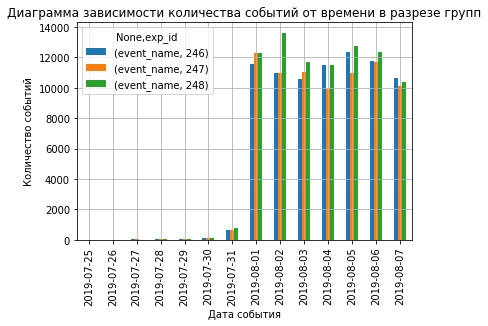

In [23]:
events_per_group.plot.bar()
plt.grid(True)
plt.title('Диаграмма зависимости количества событий от времени в разрезе групп')
plt.xlabel('Дата события')
plt.ylabel('Количество событий');

Данные становятся полными с 1 августа 2019 года.

3) Отбросим неполные данные

In [24]:
data_full = data.query('event_date >= datetime.date(2019,8,1)')

In [25]:
data_full

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


#### Количество отброшенных записей и пользователей

In [26]:
data.query('event_date < datetime.date(2019,8,1)')

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
2823,OffersScreenAppear,2413191300976302222,1564617295,247,2019-07-31 23:54:55,2019-07-31
2824,MainScreenAppear,5505110279185484837,1564617450,247,2019-07-31 23:57:30,2019-07-31
2825,MainScreenAppear,5505110279185484837,1564617462,247,2019-07-31 23:57:42,2019-07-31
2826,MainScreenAppear,5505110279185484837,1564617472,247,2019-07-31 23:57:52,2019-07-31


In [27]:
events_change_rate = (data_full['event_datetime'].count() / data['event_datetime'].count() - 1) * 100
events_change = data_full['event_datetime'].count() - data['event_datetime'].count()
print('Количество событий до фильтрации:', data['event_datetime'].count())
print('Количество событий после фильтрации:', data_full['event_datetime'].count())
print(f'Изменение количества событий после фильтрации: {events_change}')
print(f'Доля изменения количества событий после фильтрации: {round(events_change_rate, 1)}')

Количество событий до фильтрации: 243713
Количество событий после фильтрации: 240887
Изменение количества событий после фильтрации: -2826
Доля изменения количества событий после фильтрации: -1.2


In [28]:
users_change_rate = (data_full['device_id_hash'].nunique() / data['device_id_hash'].nunique() - 1) * 100
users_change = data_full['device_id_hash'].nunique() - data['device_id_hash'].nunique()
print('Количество пользователей до фильтрации:', data['device_id_hash'].nunique())
print('Количество пользователей после фильтрации:', data_full['device_id_hash'].nunique())
print(f'Изменение количества пользователейй после фильтрации: {users_change}')
print(f'Доля изменения количества пользователей после фильтрации: {round(users_change_rate, 1)}')

Количество пользователей до фильтрации: 7551
Количество пользователей после фильтрации: 7534
Изменение количества пользователейй после фильтрации: -17
Доля изменения количества пользователей после фильтрации: -0.2


Отсеяв период, за который имеются неполные данные, было потеряно 2826 событий и 17 уникальных пользователей, что составляет 1.2% и 0.2% от общего объема данных соответственно.

#### Проверка наличия трёх экспериментальных групп

In [29]:
events_per_group_full = data_full.pivot_table(
    index=['event_date'], 
    columns = 'exp_id',
    values=['event_name'],
    aggfunc='count'
)

events_per_group_full

event_name              
exp_id            246    247    248
event_date                         
2019-08-01      11561  12306  12274
2019-08-02      10946  10990  13618
2019-08-03      10575  11024  11683
2019-08-04      11514   9942  11512
2019-08-05      12368  10949  12741
2019-08-06      11726  11720  12342
2019-08-07      10612  10091  10393

После фильтрации данных остались все три экспериментальные группы. Таким образом, можно перейти к следующему шагу нашего исследования.

**Результаты проверки данных о логах:**

- данные содержат 243713 событий и 5 видов событий: MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial;
- количество уникальных пользователей в логе: 7551. В среднем каждый пользователь совершил 32 события;
- данные представлены за период с 25 июля 2019 по 7 августа 2019;
- данные становятся полными с 1 августа 2019 года;
- отсеяв период, за который имеются неполные данные, было потеряно 2826 событий и 17 уникальных пользователей, что составляет 1.2% и 0.2% от общего объема данных соответсвенно.

### Исследование воронки событий

#### Типы событий в логе и их частота

In [30]:
events_count = data_full.groupby('event_name').agg(
    {'device_id_hash': 'count'}
).sort_values(by=(['device_id_hash']), ascending = False)

events_count

,device_id_hash
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


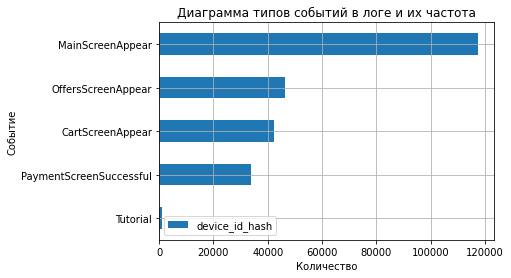

In [31]:
events_count.sort_values(by=(['device_id_hash']), ascending = True).plot.barh()
plt.grid(True)
plt.title('Диаграмма типов событий в логе и их частота')
plt.xlabel('Количество')
plt.ylabel('Событие');

Чаще всего встречалось событие MainScreenAppear (главный экран) - 117328 раз. Реже всего 1005 раз пользователи оставались на экране Tutorial (обучение).

#### Количество пользователей, совершавших каждое из событий

Сгруппируем количество уникальных пользователей по видам событий:

In [32]:
users_count = data_full.groupby('event_name').agg(
    {'device_id_hash': 'nunique'}
).sort_values(by='device_id_hash', ascending=False)
users_count

,device_id_hash
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


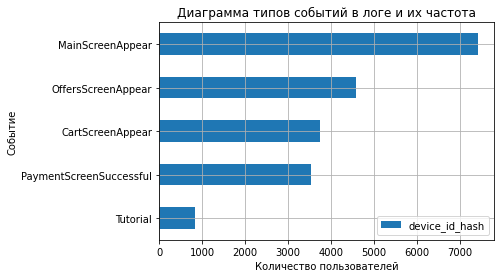

In [33]:
users_count.sort_values(by=(['device_id_hash']), ascending = True).plot.barh()
plt.grid(True)
plt.title('Диаграмма типов событий в логе и их частота')
plt.xlabel('Количество пользователей')
plt.ylabel('Событие');

In [34]:
users_count['rate'] = round(users_count['device_id_hash'] / data_full['device_id_hash'].nunique() * 100, 2)

In [35]:
users_count

,device_id_hash,rate
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Соотношение количества пользователей на каждом экране к общему числу уникальных пользователей показало:

**98.47%** всех пользователей заходит на главный экран\
**60.96%** всех пользователей заходит на экран товара/предложения\
**49.56%** всех пользователей заходит на экран корзины\
**46.97%** всех пользователей заходит на экран оплаты\
**11.15%** всех пользователей заходит на экран обучения

#### Порядок событий

 Судя по числу просмотров, события выстраиваются по следующей цепочке:
 
 1) MainScreenAppear - главный экран
 2) OffersScreenAppear	- экран товара/предложения
 3) CartScreenAppear - экран коризины
 4) PaymentScreenSuccessful - экран оплаты
 
Экран обучения/онбординг, который просматривает всего **11.15% пользователей**, а большая часть пользователей пропускает не попадает в логическую последовательность, поэтому этот этап мы исключим из воронки.

#### Расчет доли пользователей, которые проходят на следующий шаг воронки

In [36]:
users_count_final = users_count.query('event_name != "Tutorial"')
users_count_final

,device_id_hash,rate
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97


In [37]:
users_count_final['funnel_rate'] = round(users_count_final['device_id_hash'].pct_change(1), 2)

In [38]:
users_count_final['difference'] = (1 + users_count_final['funnel_rate']) * 100
users_count_final

,device_id_hash,rate,funnel_rate,difference
event_name,,,,
MainScreenAppear,7419,98.47,NaN,NaN
OffersScreenAppear,4593,60.96,-0.38,62.0
CartScreenAppear,3734,49.56,-0.19,81.0
PaymentScreenSuccessful,3539,46.97,-0.05,95.0


In [39]:
users_final = users_count_final.iloc[:, 3:]

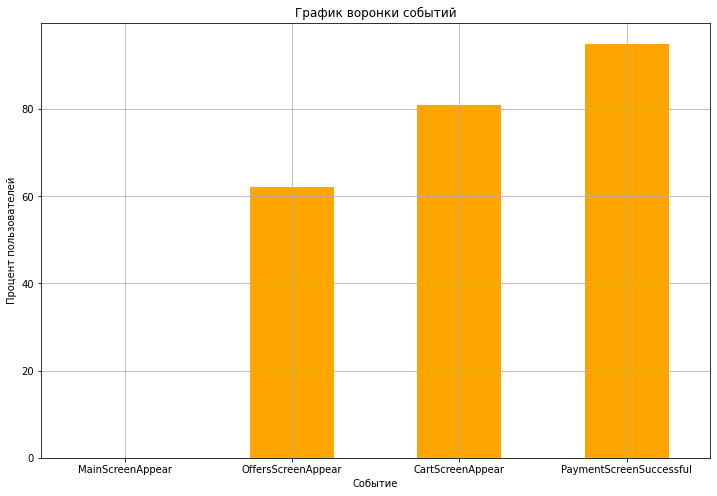

In [40]:
users_final.plot(kind='bar', ylabel='Процент пользователей', 
    xlabel='Событие', 
    figsize = (12, 8), 
    title='График воронки событий', 
    color='orange', 
    grid=True, 
    legend=False)

plt.xticks(rotation=360)
plt.show;

По воронке событий **62.0%** пользователей с главного экрана (MainScreenAppear) переходят к следующему экрану - экрану товара (OffersScreenAppear). После экрана товара **81%** пользователей переходит к корзине (CartScreenAppear). Далее **95 %** пользователей переходит к оплате (PaymentScreenSuccessful).

**Больше всего пользователей - 38%** - сервис теряет после главного экрана (MainScreenAppear).

**Результаты исследования воронки событий:**

- чаще всего посещался экран **MainScreenAppear (главный экран) - 117328 раз**. Реже всего **1005 раз** пользователи оставались на экране **Tutorial (обучение)**;
- **98.47% всех пользователей** заходит на главный экран и только **11.15% всех пользователей** заходит на экран обучения;
-  Судя по числу просмотров, события выстраиваются по следующей цепочке:
 1) MainScreenAppear - главный экран
 2) OffersScreenAppear	- экран товара/предложения
 3) CartScreenAppear - экран коризины
 4) PaymentScreenSuccessful - экран оплаты
- Экран обучения/онбординг большая часть пользователей пропускает, поэтому этот этап мы исключим из воронки.
- По воронке событий **62.0% пользователей** с главного экрана (MainScreenAppear) переходят к следующему экрану - экрану товара (OffersScreenAppear). После экрана товара **81% пользователей** переходит к корзине (CartScreenAppear). Далее **95 % пользователей** переходит к оплате (PaymentScreenSuccessful).
- **Больше всего пользователей - 38%** - сервис теряет после главного экрана (MainScreenAppear).

### Изучение результатов экспериментов

#### Количество пользователей в каждой экспериментальной группе

Исключим из исследования событие "Tutorial", поскольку, как мы выяснили, почти все пользователи его пропускают.

In [41]:
data_full = data_full.query('event_name != "Tutorial"')

In [42]:
data_full.groupby('exp_id').agg({'device_id_hash': 'nunique'})

,device_id_hash
exp_id,
246,2483
247,2512
248,2535


- В 246 контрольной группе 2483 уникальных пользователя;
- в 247 контрольной группе 2512 уникальных пользователей;
- в 248 экспериментальной группе 2535 уникальных пользователей;

In [43]:
users_a = data_full[data_full['exp_id']=='246']
users_b = data_full[data_full['exp_id']=='247']
users_c = data_full[data_full['exp_id']=='247']
users_dublicate = users_a.merge(users_b, on='device_id_hash', how='inner')
users_dublicate['device_id_hash'].nunique()

0

In [44]:
users_dublicate = users_a.merge(users_c, on='device_id_hash', how='inner')
users_dublicate['device_id_hash'].nunique()

0

In [45]:
users_dublicate = users_b.merge(users_c, on='device_id_hash', how='inner')
users_dublicate['device_id_hash'].nunique()

0

#### А/А-эксперимент. Проверка статистической разности разницы между выборками 246 и 247

In [46]:
data_full.groupby('exp_id').agg({'device_id_hash': 'nunique'}).pct_change()*100

,device_id_hash
exp_id,
246,NaN
247,1.167942
248,0.915605


Количество пользователей в контрольных группах различается не более, чем на 1 п.п. Можно проводить А/А тест.

Чтобы проверить корректность всех механизмов и расчётов, проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов.

**Посчитаем долю пользователей, совершивших событие "PaymentScreenSuccessful". Проверим, будет ли отличие между группами 246 и 247 статистически достоверным.**

In [47]:
events_per_group = data_full.query(
    'event_name == "PaymentScreenSuccessful"').groupby('exp_id').agg({'device_id_hash': 'nunique'}).reset_index()

In [48]:
events_per_group_pss = data_full.groupby('exp_id').agg({'device_id_hash': 'nunique'}).reset_index()

In [49]:
events_per_group

,exp_id,device_id_hash
0,246,1200
1,247,1158
2,248,1181


In [50]:
events_per_group_pss

,exp_id,device_id_hash
0,246,2483
1,247,2512
2,248,2535


**Для проверки гипотезы о равенстве долей применем Z-критерий:**

Н0: Статистически значимых отличий в доле пользователей, совершивших событие между группами нет.\
Н1: Статистически значимые отличия в доле пользователей, совершивших событие между группами есть

При малом объеме выборки более вероятно получить случайный  результат, например, получить различие в двух в выборках при их однородности.  Следовательно, можно взять большую вероятность ошибки первого рода. При увеличении объема выборки случайные отклонения компенсируют друг друга, и получить значимое различие в выборках при их однородности менее вероятно. Следовательно, надо брать меньший уровень значимости. Стандартными уровнями значимости являются 0,1; 0,05; 0,01

Поскольку наша выборка довольно большая в качестве **уровня значимости возьмем 0,05.**

In [51]:
alpha = 0.05

views = events_per_group['device_id_hash']
visitors = events_per_group_pss['device_id_hash']

p1 = views[0]/visitors[0]

p2 = views[1]/visitors[1]

p_combined = (views[0] + views[1]) / (visitors[0] + visitors[1])

difference = p1-p2

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors[0] + 1/visitors[1]))

distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Результат тестирования:**

Две контрольные группы оказались равны - мы можем быть уверены в точности проведенного тестирования.

#### A/B-тест. Проверка статистической разности разницы между выборками 246 и 247

В 4 пункте мы выяснили, что самое популярное событие - это **MainScreenAppear**, его пользователи посмотрели 117328 раз.

In [52]:
total_events_per_group = data_full.groupby('event_name').agg(
    {'device_id_hash': 'nunique'}
).sort_values(
    by=(['device_id_hash']), ascending = False)

total_events_per_group

,device_id_hash
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [53]:
popular_events_per_group = data_full.query(
    'event_name == "MainScreenAppear"').groupby('exp_id').agg({'device_id_hash': 'nunique'}).reset_index()

In [54]:
popular_events_per_group

,exp_id,device_id_hash
0,246,2450
1,247,2476
2,248,2493


In [55]:
data_full.groupby(
    ['event_name', 'exp_id']).agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)

device_id_hash
event_name              exp_id                
MainScreenAppear        248               2493
                        247               2476
                        246               2450
OffersScreenAppear      246               1542
                        248               1531
                        247               1520
CartScreenAppear        246               1266
                        247               1238
                        248               1230
PaymentScreenSuccessful 246               1200
                        248               1181
                        247               1158

Главный экран посетели:
- 2450 уникальных пользователей из группы 246;
- 2476 уникальных пользователей из группы 247;
- 2493 уникальных пользователя из группы 248

Чтобы посчитать долю пользователей посетивших каждый экран по каждой группе напишем функцию:

In [56]:
def rate (df1, event, exp):
    total_per_group = np.array(df1[df1['exp_id'] == exp]['device_id_hash'].nunique())
    group_users = np.array(df1[(df1['event_name'] == event) & (df1['exp_id'] == exp)]['device_id_hash'].nunique())
    rate = group_users / total_per_group
    print('Событие:', event)
    print(f'Доля пользователей для группы {exp}: {round(rate, 2)}')

In [57]:
for event in data_full['event_name'].unique():
    rate(data_full, event, 246)
    print()
    
for event in data_full['event_name'].unique():
    rate(data_full, event, 247)
    print()

for event in data_full['event_name'].unique():
    rate(data_full, event, 248)
    print()

Событие: MainScreenAppear
Доля пользователей для группы 246: 0.99

Событие: OffersScreenAppear
Доля пользователей для группы 246: 0.62

Событие: CartScreenAppear
Доля пользователей для группы 246: 0.51

Событие: PaymentScreenSuccessful
Доля пользователей для группы 246: 0.48

Событие: MainScreenAppear
Доля пользователей для группы 247: 0.99

Событие: OffersScreenAppear
Доля пользователей для группы 247: 0.61

Событие: CartScreenAppear
Доля пользователей для группы 247: 0.49

Событие: PaymentScreenSuccessful
Доля пользователей для группы 247: 0.46

Событие: MainScreenAppear
Доля пользователей для группы 248: 0.98

Событие: OffersScreenAppear
Доля пользователей для группы 248: 0.6

Событие: CartScreenAppear
Доля пользователей для группы 248: 0.49

Событие: PaymentScreenSuccessful
Доля пользователей для группы 248: 0.47



На первый взгляд, значительных отличий в поведении групп нет. Проверим, будет ли отличие между группами статистически достоверным. 

**Для проверки гипотезы о равенстве долей применем Z-критерий:**

Н0: Статистически значимых отличий в доле пользователей, совершивших событие между контрольными группами нет.\
Н1: Статистически значимые отличия в доле пользователей, совершивших событие между контрольными группами есть

Чтобы избежать ошибок первого рода, откорректируем уровень значимости (a) с помощью поправки Бонферрони.

Формула поправки Бонферрони выглядит следующим образом:
α новый = α исходный / n, где n - количество тестов

Поскольку мы будем проводить 16 тестов подряд α новый = 0.05 / 16

In [58]:
def z_test (data_1, data_2, event, alpha, n):
    bonferroni_alpha = alpha / n
    visitors = np.array([data_1['device_id_hash'].nunique(), data_2['device_id_hash'].nunique()])
    views = np.array([data_1[data_1['event_name'] == event]['device_id_hash'].nunique(), data_2[data_2['event_name'] == event]['device_id_hash'].nunique()])
    p1 = views[0]/visitors[0]
    p2 = views[1]/visitors[1]
    p_combined = (views[0] + views[1]) / (visitors[0] + visitors[1])
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors[0] + 1/visitors[1]))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие:', event)
    print('p-значение: ', p_value)
    
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

In [59]:
for event in data_full['event_name'].unique():
    z_test(data_full[data_full['exp_id'] == 246], data_full[data_full['exp_id'] == 247], event, 0.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Результат тестирования контрольных групп:**

Во всех результатх значение p оказалось выше критического уровня значимости с поправкой Бонферрони.
Между двумя контрольными группами нет статистически значимого отличия. Таким образом, можем перейти к A/B-тестированию.

#### A/B-тест. Проверка статистической разности разницы между экспериментальной группой 248 и контрольными группами 246, 247. Сравнение с объединенной контрольной группой

1) Тестирование контрольнй группы 246 и экспериментальной группы 248:

**Для проверки гипотезы о равенстве долей применем Z-критерий:**

Н0: Статистически значимых отличий в доле пользователей, совершивших событие между контрольной 246 и экспериментальной группой нет.\
Н1: Статистически значимые отличия в доле пользователей, совершивших событие между контрольной и экспериментальной группой есть

In [60]:
for event in data_full['event_name'].unique():
    z_test(data_full[data_full['exp_id'] == 246], data_full[data_full['exp_id'] == 248], event, 0.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Результат тестирования контрольной группы 246 и экспериментальной группы 248:**

Во всех результатах значение p оказалось выше критического уровня значимости с поправкой Бонферрони.
Между двумя группами нет статистически значимого отличия.

2) Тестирование контрольнй группы 247 и экспериментальной группы 248:

Н0: Статистически значимых отличий в доле пользователей, совершивших событие между контрольной 247 и экспериментальной группой нет.\
Н1: Статистически значимые отличия в доле пользователей, совершивших событие между контрольной и экспериментальной группой есть

In [61]:
for event in data_full['event_name'].unique():
    z_test(data_full[data_full['exp_id'] == 247], data_full[data_full['exp_id'] == 248], event, 0.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Результат тестирования контрольной группы 247 и экспериментальной группы 248:**

Во всех результатах значение p оказалось выше критического уровня значимости с поправкой Бонферрони.
Между двумя группами нет статистически значимого отличия.

3) Тестирование объединенной контрольнй группы и экспериментальной группы 248:

Н0: Статистически значимых отличий в доле пользователей, совершивших событие между объединенной контрольной и экспериментальной группой нет.\
Н1: Статистически значимые отличия в доле пользователей, совершивших событие между контрольной и экспериментальной группой есть

In [62]:
for event in data_full['event_name'].unique():
    z_test(data_full[(data_full['exp_id'] == 246) | (data_full['exp_id'] == 247)], 
           data_full[data_full['exp_id'] == 248], event, 0.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Результат тестирования объединенной контрольной группы и экспериментальной группы 248:**

Значение p оказалось выше критического уровня значимости с поправкой Бонферрони.
Между двумя группами нет статистически значимого отличия.

**Таким образом, изменение шрифта в приложении никак не повлияло на поведение пользователей.**

### Общий вывод

**Результаты работы:**

- Изучена общая информация об имеющихся данных, проведена проверка;
- исследована воронка событий; 
- проведена проверка статистической значимости разности контрольных и экспериментальной гуппы;
- изучены результаты экспериментов;
- составлен общий вывод.

**Исследование воронки событий показало:**

- чаще всего посещался экран **MainScreenAppear (главный экран) - 117328 раз**. Реже всего **1005 раз** пользователи оставались на экране **Tutorial (обучение)**;
- отсеяв период, за который имеются неполные данные (период до 1 августа 2019 года), было потеряно 2826 событий и 17 уникальных пользователей, что составляет 1.2% и 0.2% от общего объема данных соответственно;
- **98.47% всех пользователей или 7419 пользователей** заходит на главный экран и только **11.15% всех пользователей** заходит на экран обучения. На экран карточки товара OffersScreenAppear зашло **4593 пользователя**, на экран корзины CartScreenAppear - **3734**, а до экрана оплаты PaymentScreenSuccessful	дошло **3539 пользователей**;
- по воронке событий **62.0% пользователей** с главного экрана (MainScreenAppear) переходит к следующему экрану - экрану товара (OffersScreenAppear). После экрана товара **81% пользователей** переходит к корзине (CartScreenAppear). Далее **95 % пользователей** переходит к оплате (PaymentScreenSuccessful).
- **больше всего пользователей - 38%** - сервис теряет после главного экрана (MainScreenAppear).

**Анализ A/A/B-теста позволил нам сделать следующие выводы:**

- в 246 контрольной группе **2483** уникальных пользователя, в 247 контрольной группе **2512** уникальных пользователей, в 248 экспериментальной группе **2535** уникальных пользователей. Пользователей, которые числятся сразу в нескольких группах не обнаружено;
- в результате тестирования двух контрольных групп, **статистически зачимых отличий в доле пользователей, совершивших событие не выявлено**, что дало нам уверенность в точности проведенного тестирования;
- статистически значимых отличий в доле пользователей, совершивших событие между контрольными 246, 247 и экспериментальной группой не установлено. **Также значимых отличий не обнаружено между объединенной контрольной и экспериментальной группой.**

**Таким образом, внесенные дизайнерами изменения в интерфейс приложения никаким образом не повлияли на поведение пользователей. Стоит проверить целесообразность наличия экрана Tutorial, который просматривают лишь 11.15% пользователей, а также выяснить, почему 38% пользователей не переходит дальше главного экрана.**